<a href="https://colab.research.google.com/github/pachterlab/CWGFLHGCCHAP_2021/blob/master/notebooks/CellAtlasAnalysis/neuronSubpop_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!date

Fri Aug 21 00:45:00 UTC 2020


### **Download Data**

In [1]:
import requests
from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
    url = 'https://api.datacite.org/dois/'+doi+'/media'
    r = requests.get(url).json()
    netcdf_url = r['data'][0]['attributes']['url']
    r = requests.get(netcdf_url,stream=True)
    #Set file name
    fname = doi.split('/')[-1]+ext
    #Download file with progress bar
    if r.status_code == 403:
        print("File Unavailable")
    if 'content-length' not in r.headers:
        print("Did not get file")
    else:
        with open(fname, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            pbar = tnrange(int(total_length/1024), unit="B")
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    pbar.update()
                    f.write(chunk)
        return fname

In [2]:
#Kallisto bus clustered starvation data, h5ad
download_file('10.22002/D1.1796','.gz')

#Starvation h5ad data, all nonzero genes included, filtered for 'real cells' from de-multiplexing
download_file('10.22002/D1.1797','.gz')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


'D1.1797.gz'

In [3]:
#Human ortholog annotations
download_file('10.22002/D1.1819','.gz')

#Panther annotations
download_file('10.22002/D1.1820','.gz')

#GO Terms
download_file('10.22002/D1.1822','.gz')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


'D1.1822.gz'

In [4]:
#Previously saved neuron subpopulations
download_file('10.22002/D1.1804','.gz')

#Previously saved marker genes for neurons
download_file('10.22002/D1.1837','.gz')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


'D1.1837.gz'

In [5]:
!gunzip *.gz

In [6]:
!pip install --quiet anndata
!pip install --quiet scanpy==1.7.0rc1

!pip install --quiet louvain


     |████████████████████████████████| 133kB 7.7MB/s 
     |████████████████████████████████| 10.2MB 7.8MB/s 
     |████████████████████████████████| 71kB 9.6MB/s 
     |████████████████████████████████| 71kB 9.5MB/s 
     |████████████████████████████████| 2.2MB 7.0MB/s 
     |████████████████████████████████| 3.2MB 42.3MB/s 


In [7]:
!pip3 install --quiet rpy2

###**Import Packages** 

In [21]:
#Install Packages
import random
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
import scipy.sparse

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import (KNeighborsClassifier,NeighborhoodComponentsAnalysis)
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

#import scrublet as scr

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('axes',edgecolor='black')
%matplotlib inline
sc.set_figure_params(dpi=125)

import seaborn as sns
sns.set(style="whitegrid")
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### **Read in Previously Saved Data**

In [9]:
#Read in h5ad file
bus_fs_combo = anndata.read("D1.1796")

#Previously saved neurons
neurons = anndata.read("D1.1804")

#Read in annotations
from io import StringIO

hg_ortho_df = pd.read_csv(StringIO(''.join(l.replace('|', '\t') for l in open('D1.1819'))),
            sep="\t",header=None,skiprows=[0,1,2,3])

hg_ortho_df[['XLOC','TCONS']] = hg_ortho_df[13].str.split(expand=True) 
hg_ortho_df[['Gene','gi']] = hg_ortho_df[3].str.split(expand=True) 
hg_ortho_df['Description']= hg_ortho_df[11]


panther_df = pd.read_csv('D1.1820',
            sep="\t",header=None) #skiprows=[0,1,2,3]



goTerm_df = pd.read_csv('D1.1822',
            sep=" ",header=None) #skiprows=[0,1,2,3]

bus_fs_combo

AnnData object with n_obs × n_vars = 13673 × 8696
    obs: 'batch', 'n_counts', 'n_countslog', 'louvain', 'leiden', 'orgID', 'fed', 'starved', 'fed_neighbor_score', 'cellRanger_louvain', 'annos', 'new_cellRanger_louvain', 'annosSub'
    var: 'n_counts', 'mean', 'std'
    uns: 'annosSub_colors', 'annos_colors', 'cellRanger_louvain_colors', 'cellRanger_louvain_sizes', "dendrogram_['new_cellRanger_louvain']", 'dendrogram_new_cellRanger_louvain', 'fed_colors', 'fed_neighbor_score_colors', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'new_cellRanger_louvain_colors', 'orgID_colors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_nca', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [10]:
raw_fs_combo = anndata.read('D1.1797')

raw_fs_combo = raw_fs_combo[bus_fs_combo.obs_names,]
#Transfer info from embedded version
raw_fs_combo.obs['cellRanger_louvain'] = pd.Categorical(bus_fs_combo.obs['cellRanger_louvain'])
raw_fs_combo.obs['fed'] = pd.Categorical(bus_fs_combo.obs['fed'])
raw_fs_combo.obsm['X_tsne'] = bus_fs_combo.obsm['X_tsne']

raw_fs_combo


Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 13673 × 46716
    obs: 'batch', 'cellRanger_louvain', 'fed'
    obsm: 'X_tsne'

####**Generating Neuron Subpopulations**

We begin by restricting analysis to four clusters that contain neuron subpopulations (31,26,6 and 9). After constraining the single-cell count matrices to the relevant cells, we examine the variance explained in the top principal components, and based on the "elbow plot" continue analysis with 15 principal components. 

Trying to set attribute `.obs` of view, copying.


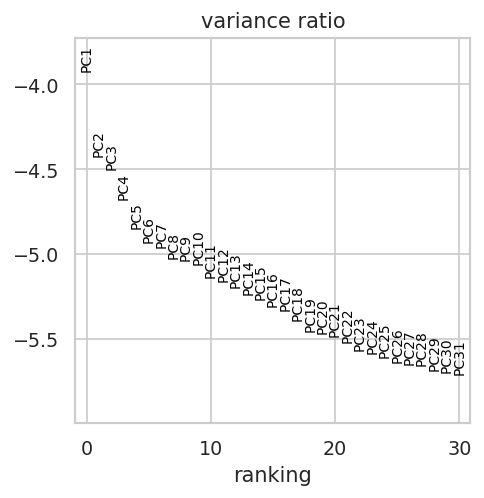

In [ ]:
# #Neurons, start from raw counts + unfiltered genes
neurons = raw_fs_combo[raw_fs_combo.obs['cellRanger_louvain'].isin([31,26,6,9])]
sc.pp.filter_cells(neurons, min_counts=0)
sc.pp.filter_genes(neurons, min_counts=0)

sc.pp.normalize_per_cell(neurons, counts_per_cell_after=1e4)

sc.pp.log1p(neurons)

sc.pp.highly_variable_genes(neurons,n_top_genes=2000,n_bins=50)

neurons = neurons[:,neurons.var['highly_variable']]

sc.pp.scale(neurons, max_value=10)

sc.tl.pca(neurons, n_comps=60)
sc.pl.pca_variance_ratio(neurons, log=True)

sc.pp.neighbors(neurons,n_neighbors=15, n_pcs=15) #n_neighbors=5, n_pcs=15,use_rep='X_nca'
sc.tl.louvain(neurons,resolution=1,key_added='louvain_neur',random_state=42)#Clustering algorithm,resolution=0.5

Next, we perform Louvain clustering to identify distinct neuron subpopulations, and we plot them using a UMAP reduction of the count matrix. The plot on the left shows the 15 Louvain derived clusters; the plot on the right shows the same UMAP representation of the cells but colored according to the clusters obtained from clustering with all the cells. This shows that a reclustering on the restricted cell x gene matrix produces a refinement of the original clusters.

In [ ]:
sc.tl.louvain(neurons,resolution=2.5,key_added='louvain_neur',random_state=42)#Clustering algorithm,resolution=0.5

In [ ]:
neurons

AnnData object with n_obs × n_vars = 1387 × 2000
    obs: 'batch', 'cellRanger_louvain', 'fed', 'n_counts', 'louvain_neur'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'louvain'
    obsm: 'X_tsne', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

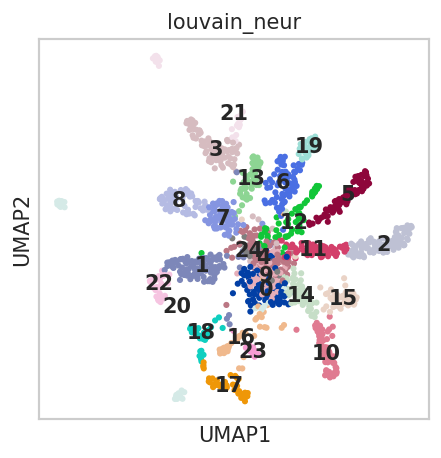

In [ ]:
sc.tl.tsne(neurons, n_pcs=15,perplexity=25,random_state = 42) #learning_rate=250
sc.tl.umap(neurons,random_state=42,spread=2.5, min_dist=1)

neurons.obs['cellAtlasClusters'] = pd.Categorical(neurons.obs['cellRanger_louvain'] )
sc.pl.umap(neurons, color=['louvain_neur'],color_map='viridis',size=50,legend_loc='on data')

The plots below show the cells expressing several different neuropeptides:

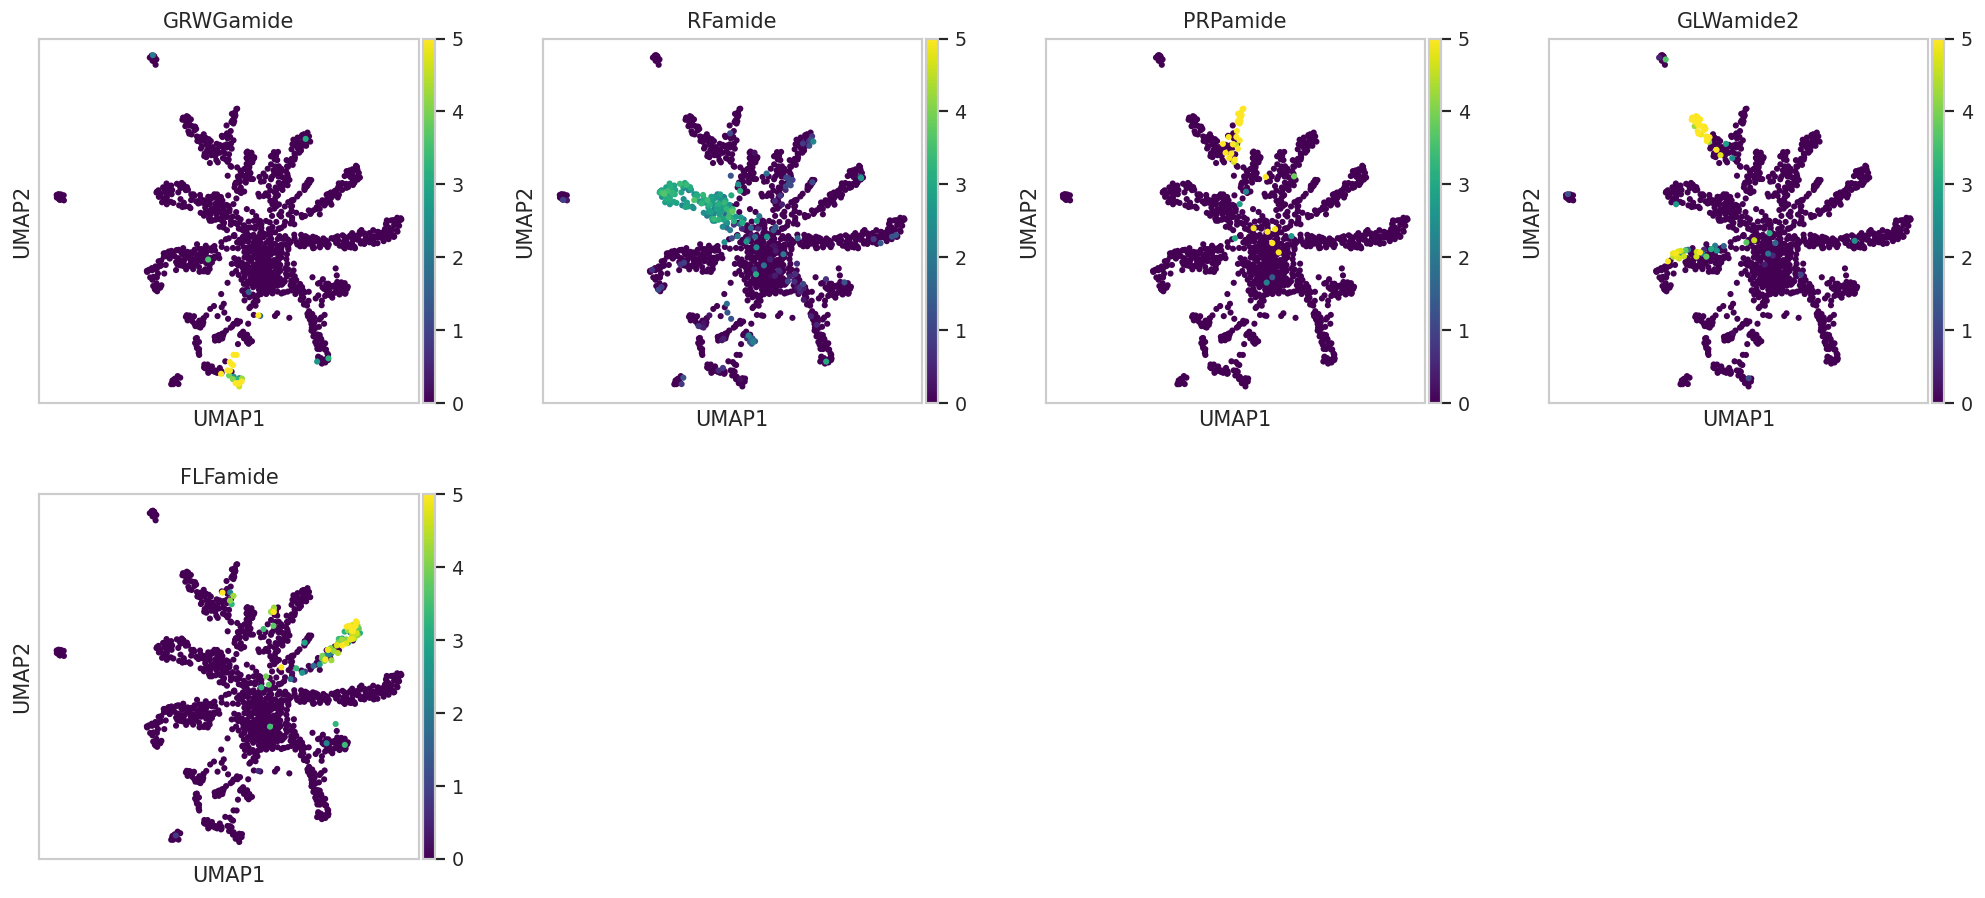

In [ ]:
sc.pl.umap(neurons, color=['XLOC_040584','XLOC_019434','XLOC_042761','XLOC_017097',
                           'XLOC_004021'],color_map='viridis',size=50,legend_loc='on data',
           title=['GRWGamide','RFamide','PRPamide','GLWamide2',
                  'FLFamide'],vmin=0,vmax=5)




Next, we identify marker genes for each of the 15 Louvain clusters determined for the neuron subpopulation, and we annotate them using the Panther database, gene ontology (GO) terms and via orthology searches.

In [ ]:
#Get top n marker genes for each cluster

#Keep top 100 genes, 'louvain_neur' is label for neuron clusters determined using Louvain clustering algorithm
sc.tl.rank_genes_groups(neurons, 'louvain_neur',n_genes = 100,method='wilcoxon') #Using non-parametric test for significance
neurons

AnnData object with n_obs × n_vars = 1387 × 2000
    obs: 'batch', 'cellRanger_louvain', 'fed', 'n_counts', 'louvain_neur', 'cellAtlasClusters'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'louvain', 'umap', 'louvain_neur_colors', 'cellAtlasClusters_colors', 'rank_genes_groups'
    obsm: 'X_tsne', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
#Make dataframe, with 100 marker genes for each cluster + annotations
neuron_clusters = np.unique(neurons.obs['louvain_neur'])
neuron_markers = pd.DataFrame()

neurClus = []
markerGene = []
padj = []
orthoGene = []
orthoDescr = []

pantherNum = []
pantherDescr = []

goTerms = []

for i in neuron_clusters:
  genes = neurons.uns['rank_genes_groups']['names'][str(i)]

  neurClus += list(np.repeat(i,len(genes)))
  markerGene += list(genes)
  padj += list(neurons.uns['rank_genes_groups']['pvals_adj'][str(i)])

  for g in genes:
        
    sub_df = hg_ortho_df[hg_ortho_df.XLOC.isin([g])]
    panth_df = panther_df[panther_df[0].isin([g])]
    go_df = goTerm_df[goTerm_df[0].isin([g])]

    if len(sub_df) > 0:
      #Save first result for gene/description
      orthoGene += [list(sub_df.Gene)[0]]
      orthoDescr += [list(sub_df.Description)[0]]
    else:
      orthoGene += ['NA']
      orthoDescr += ['NA']


    if len(panth_df) > 0:
      pantherNum += [list(panth_df[1])]
      pantherDescr += [list(panth_df[2])]
    else:
      pantherNum += ['NA']
      pantherDescr += ['NA']


    if len(go_df) > 0:
      goTerms += [list(go_df[1])]
    else:
      goTerms += ['NA']
 

neuron_markers['neurClus'] = neurClus
neuron_markers['markerGene'] = markerGene
neuron_markers['padj'] = padj

neuron_markers['orthoGene'] = orthoGene
neuron_markers['orthoDescr'] = orthoDescr

neuron_markers['pantherID'] = pantherNum
neuron_markers['pantherDescr'] = pantherDescr

neuron_markers['goTerms'] = goTerms
     
neuron_markers.head()
#list(neurons.uns['rank_genes_groups']['names']['1'])




In [ ]:
#Write to csv
neuron_markers.to_csv('neuron_marker_annotations.csv')

#Read in csv (previously saved version, uploaded to Box)
neuron_markers = pd.read_csv('neuron_marker_annotations.csv',
            sep=",")
neuron_markers.head()

,Unnamed: 0,neurClus,markerGene,padj,orthoGene,orthoDescr,pantherID,pantherDescr,goTerms
0,0,0,XLOC_015355,3.187630e-14,NaN,NaN,['PTHR46628'],['PIRNA BIOGENESIS PROTEIN EXD1'],"['GO:0016070,GO:0016787,GO:0016072,GO:0044238,..."
1,1,0,XLOC_011074,1.840292e-11,TUBA1C,tubulin alpha-1C chain isoform a [Homo sapiens],['PTHR11588:SF408'],['TUBULIN ALPHA CHAIN'],"['GO:0045298,GO:0005856,GO:0005200,GO:0005622,..."
2,2,0,XLOC_030920,1.122410e-04,NaN,NaN,['PTHR19290'],['BASIC HELIX-LOOP-HELIX PROTEIN NEUROGENIN-RE...,[nan]
3,3,0,XLOC_044603,3.908375e-03,NDUFV2,NADH dehydrogenase [ubiquinone] flavoprotein ...,['PTHR10371'],['NADH DEHYDROGENASE UBIQUINONE FLAVOPROTEIN...,"['GO:0043234,GO:0005886,GO:0016020,GO:0032991,..."
4,4,0,XLOC_004445,4.765108e-01,NaN,NaN,['PTHR28618'],['CENTROSOMAL PROTEIN POC5'],[nan]


In [ ]:
neurons.write('neuron_subpops_fs.h5ad')

#### **Neuron Subpopulation Plots**

Hierarchical Clustering of Neuron Subpopulations

In [11]:
#Previously saved neurons
neurons = anndata.read("D1.1804")
print(neurons)

raw_fs_combo = anndata.read('D1.1797')

raw_fs_combo = raw_fs_combo[bus_fs_combo.obs_names,]
#Transfer info from embedded version
raw_fs_combo.obs['cellRanger_louvain'] = pd.Categorical(bus_fs_combo.obs['cellRanger_louvain'])
raw_fs_combo.obs['fed'] = pd.Categorical(bus_fs_combo.obs['fed'])
raw_fs_combo.obsm['X_tsne'] = bus_fs_combo.obsm['X_tsne']

raw_fs_combo


Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 1387 × 2000
    obs: 'batch', 'cellRanger_louvain', 'fed', 'n_counts', 'louvain_neur', 'test_louvain'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cellRanger_louvain_colors', 'hvg', 'louvain', 'louvain_neur_colors', 'neighbors', 'pca', 'rank_genes_groups', 'test_louvain_colors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


AnnData object with n_obs × n_vars = 13673 × 46716
    obs: 'batch', 'cellRanger_louvain', 'fed'
    obsm: 'X_tsne'

To examine similarities between different subpopulations we infer a dendogram based on similarities of cells in the different Louvain derived clusters:

In [12]:
sc.tl.dendrogram(neurons,'louvain_neur',linkage_method='ward')
neurons

AnnData object with n_obs × n_vars = 1387 × 2000
    obs: 'batch', 'cellRanger_louvain', 'fed', 'n_counts', 'louvain_neur', 'test_louvain'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cellRanger_louvain_colors', 'hvg', 'louvain', 'louvain_neur_colors', 'neighbors', 'pca', 'rank_genes_groups', 'test_louvain_colors', 'umap', 'dendrogram_louvain_neur'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [13]:
#neurons.uns['dendrogram_louvain_neur'] = neurons.uns["dendrogram_['louvain_neur']"]

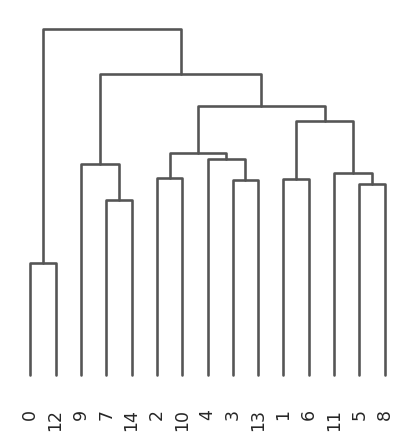

In [14]:
sc.pl.dendrogram(neurons,'louvain_neur')

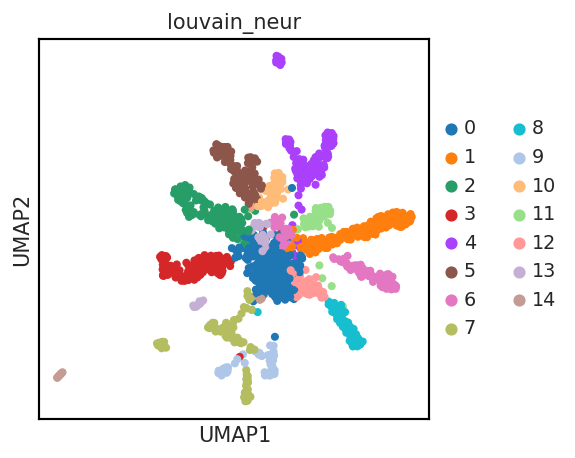

In [25]:
sc.pl.umap(neurons,color=['louvain_neur'])


Plot marker genes

In [ ]:
neuron_markers = pd.read_csv('D1.1837') 
neuron_markers.head()



In [ ]:
# topGenes = []
# var_groups = []
# var_labels = []
# ind = 0
# n_genes = 10
# for i in np.unique(neuron_markers.neurClus):
#   sub = neuron_markers[neuron_markers.neurClus == i]
#   sub.sort_values(by='padj',ascending=True)

#   #noDups = [i for i in sub.markerGene if i not in topGenes] #Remove duplicate genes
#   topGenes += list(sub.markerGene[0:n_genes])

#   var_groups += [(ind,ind+n_genes-1)]
#   var_labels += [str(i)]
#   ind += n_genes



In [ ]:
# forBLAST = neuron_markers[neuron_markers.markerGene.isin(topGenes)]
# forBLAST.to_csv('blastNeuroPop_Genes.csv')

In [15]:
# Use raw adata with all genes, to plot any gene expression in neuron subpopulations
neurons_raw = raw_fs_combo[raw_fs_combo.obs['cellRanger_louvain'].isin([31,26,6,9])]


sc.pp.filter_cells(neurons_raw, min_counts=0)
sc.pp.filter_genes(neurons_raw, min_counts=0)

sc.pp.normalize_per_cell(neurons_raw, counts_per_cell_after=1e4)

sc.pp.log1p(neurons_raw)

#sc.pp.scale(neurons_raw,max_value=10)
neurons_raw.obs['louvain_neur'] = neurons.obs['louvain_neur']
neurons_raw.obsm['X_tsne'] = neurons.obsm['X_tsne']
neurons_raw.obsm['X_umap'] = neurons.obsm['X_umap']

neurons_raw.uns['dendrogram_louvain_neur'] = neurons.uns['dendrogram_louvain_neur']
neurons_raw.uns['louvain_neur_colors'] = neurons.uns['louvain_neur_colors']


Trying to set attribute `.obs` of view, copying.


Trying to set attribute `.var` of view, copying.


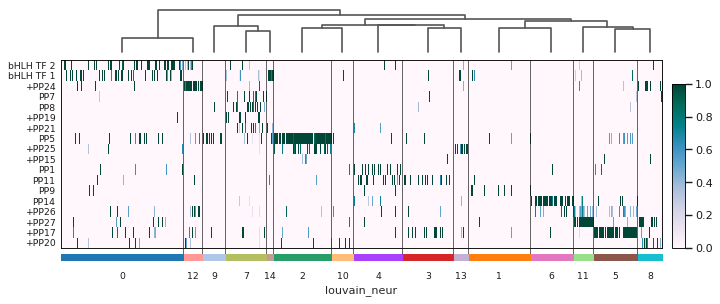

In [19]:
#Plot main figure genes
#'XLOC_010412' bHLH TF 1, 'XLOC_010752' bHLH TF 3

topGenes = ['XLOC_030920','XLOC_018937','XLOC_035224','XLOC_008730' ,'XLOC_014624', 
            'XLOC_030120','XLOC_038155',
            'XLOC_040584','XLOC_008764', 'XLOC_040209', 'XLOC_010892',    'XLOC_041402',
            'XLOC_004021','XLOC_019434',
            'XLOC_003339','XLOC_042761','XLOC_017097',
            'XLOC_021799'] 
neurons_sigTop = neurons_raw[:,topGenes]

labels = ['bHLH TF 1','bHLH TF 2','+PP24','+PP26','+PP27',  
          '+PP17','+PP20',
          'PP7','PP8', '+PP19','+PP21',    'PP9',
          'PP14','PP5',
          '+PP15','PP1','PP11',
          '+PP25']


neurons_sigTop.var['names'] = labels

toPlotLabs = ['bHLH TF 2','bHLH TF 1','+PP24','PP7','PP8', '+PP19','+PP21','PP5','+PP25','+PP15','PP1','PP11','PP9','PP14','+PP26','+PP27',  
              '+PP17','+PP20' ]

sc.set_figure_params(scanpy=True, fontsize=10)
sc.pl.heatmap(neurons_sigTop, toPlotLabs , groupby='louvain_neur', dendrogram=True,show_gene_labels=True,
              gene_symbols = 'names',swap_axes=True,
              cmap='PuBuGn',standard_scale='obs',save='neuronMarkers.pdf') #var_group_positions =var_groups ,var_group_labels = var_labels

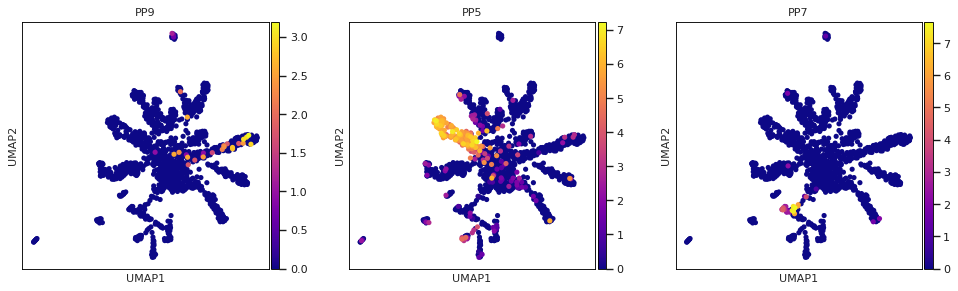

In [ ]:
sc.pl.umap(neurons_raw,color=['XLOC_041402','XLOC_019434','XLOC_040584'],title=['PP9','PP5','PP7'],color_map='plasma')

In [ ]:
#Composition of broad cell types between fed and starved , cell counts
counts = pd.DataFrame(columns =['count', 'orgID','condition','cluster']) 
clusters = np.unique(neurons.obs['louvain_neur'])

c = []
org = []
cond = []
clus = []

#orgs = np.unique(neurons.obs['orgID'])
conds = [True,False]#['True', 'False']
for cl in clusters:
    data = neurons[neurons.obs['louvain_neur'].isin([cl])]
    
    for cd in conds:
        #c_data = data[data.obs['condition'].isin([cd])]
        
        #for o in orgs:
        pos = (data.obs['fed'].isin([cd])) #& (data.obs['orgID'].isin([o]))
        org_data = data[pos]
        c += [org_data.n_obs]
            
        if cd == True:#'True':
            cond += ['fed']
        else:
            cond += ['starved']
        clus += [cl]
            
                
print(len(c))


   
    
counts['count'] = c
counts['condition'] = cond
counts['cluster'] = clus

30


In [ ]:
counts = counts[counts['count']> 0 ]
counts.head()

,count,orgID,condition,cluster
0,140,NaN,fed,0
1,144,NaN,starved,0
2,42,NaN,fed,1
3,101,NaN,starved,1
4,19,NaN,fed,10


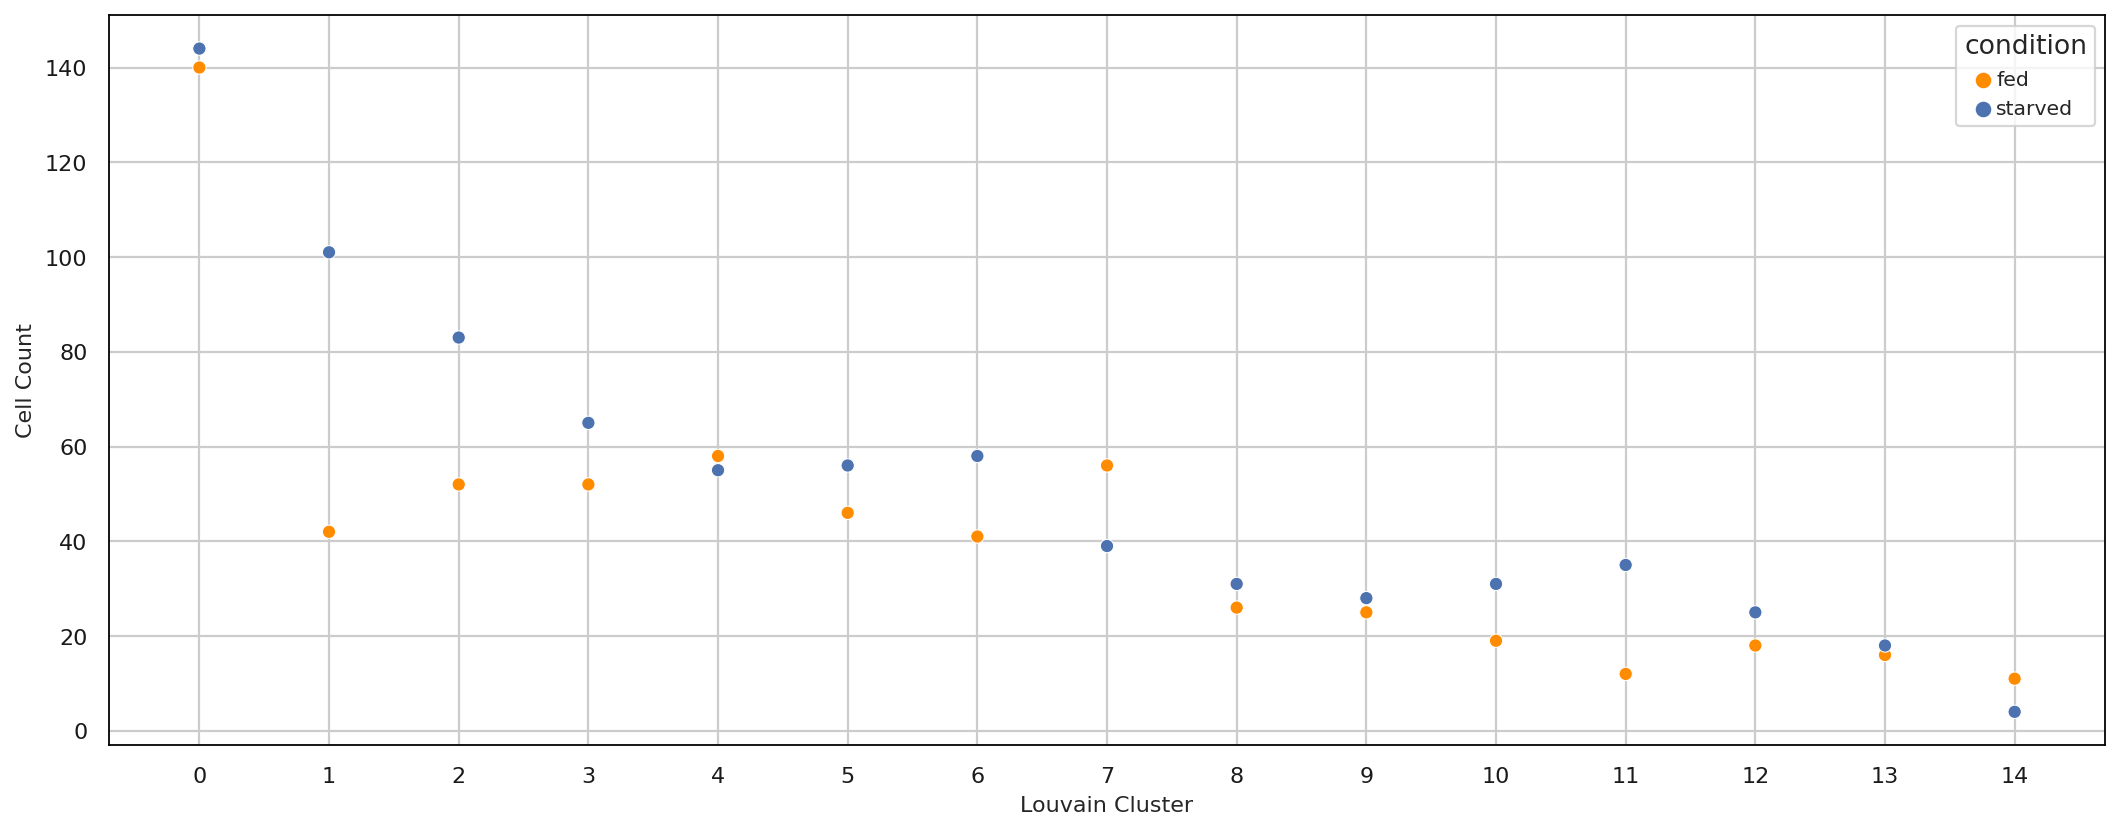

In [ ]:
counts['cluster'] = [int(i) for i in counts['cluster']] 
plt.figure(figsize=(16, 6))
ax = sns.scatterplot(x="cluster", y="count", hue="condition", data=counts,palette=["darkorange", "b"])
ax.set(ylabel='Cell Count')
ax.set(xlabel='Louvain Cluster')
ax.xaxis.set_ticks(np.unique(counts.cluster))  

plt.show()